In [1]:
!pip install xlrd

In [2]:
#Import relevant packages
import numpy as np
#import networkx
import matplotlib.pyplot as plt
import joblib
import sklearn
import pandas as pd
#import scprep
#import phate
import scipy
#import demap
from sklearn.metrics import roc_curve
import os
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import sys
#Importing logistic regression model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import random 
#os.chdir("C:\\Users\\13347\\Documents\\Yale\\MGH_Research\\Bortfield_Ali")
#from base import *
#from test import *
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from math import nan, isnan

In [2]:

#Reading in Data
raw_data = pd.read_excel('Patient_and_Treatment_Characteristics.xls')
craw_data = pd.read_excel('Patient_and_Treatment_Characteristics.xls')

print(craw_data.shape)

#--------------------# 
#----Data Preprocessing-----#
#--------------------#

#Dropping redundant or unnecessary columns
rdatacolumns = raw_data.columns
raw_data = raw_data.drop(columns = rdatacolumns[0])
raw_data = raw_data.drop(columns = rdatacolumns[3])
raw_data = raw_data.drop(columns = rdatacolumns[18])
rdatacolumns = raw_data.columns # Getting column names

#Changing Categorical data to numbered categorical
catlist = np.array([0,2,3,4,5,6,7,9,10,17,18,21,25,26,27,28,29,30,31,33,35,38,39,43,68,69,71,74,76,77,78,79])
for i in catlist:
    raw_data[rdatacolumns[i]] = raw_data[rdatacolumns[i]].astype('category')
    raw_data.iloc[:,i] = raw_data[rdatacolumns[i]].cat.codes

# Converting -1's back to nan's
for i in range(215):
    for j in range(80):
        if raw_data.iloc[i,j] == -1:
            raw_data.iloc[i,j] = np.nan

#Dropping Stop RT/Start RT and converting to one variable: Time to Start
nstart = pd.to_datetime(raw_data['Date of Diagnosis'].values) # Convert to datetime object
nstop = pd.to_datetime(raw_data['Date Start RT'].values) # Convert to datetime object
timedif = nstop - nstart
ntimedif = timedif/np.timedelta64(1,'D')
timetostart = ntimedif.astype(float)
dat2 = pd.DataFrame({'Time to Start Tx (Days)': timetostart})
raw_data = raw_data.join(dat2)


# Chagning Date Stop RT/date of recurrence to one variable: Time to recurrence 
nstart = pd.to_datetime(raw_data['Date Stop RT'].values) # Convert to datetime object
nstop = pd.to_datetime(raw_data['Date of recurrence'].values) # Convert to datetime object
timedif = nstop - nstart
ntimedif = timedif/np.timedelta64(1,'D')
timetorecur = ntimedif.astype(float)
dat2 = pd.DataFrame({'Time to Recurrence (Days)': timetorecur})
raw_data = raw_data.join(dat2)


# Converting start date to numbered categorical
start = raw_data['Date Start RT']
starter = start.values
nstart = pd.to_datetime(starter)
startdate = nstart.strftime("%Y")
nint = startdate.astype(int)
stdate = np.zeros((215))
a = 0
for i in range(215):
    
    if nint[i] < 2000:
        stdate[i] = 0
    
    if nint[i] > 1999 and nint[i] <2010:
        stdate[i] = 1
        
    if nint[i] > 2009:
        stdate[i] = 2
dat2 = pd.DataFrame({'Start Date': stdate})
raw_data = raw_data.join(dat2)


# Dropping more redundant categorical variables
raw_data = raw_data.drop(columns = 'CT sim date')
raw_data = raw_data.drop(columns = 'post-RT imaging date')
raw_data = raw_data.drop(columns = 'Pre-RT Imaging Date')
raw_data = raw_data.drop(columns = 'Date Start RT')
raw_data = raw_data.drop(columns = 'Date Stop RT')
raw_data = raw_data.drop(columns = 'Date of recurrence')
raw_data = raw_data.drop(columns = 'Date of Diagnosis')
raw_data = raw_data.drop(columns = 'Last Contact Date')
raw_data = raw_data.drop(columns = 'Recurrence imaging date')
raw_data = raw_data.drop(columns = 'Date Feeding tube placed')
raw_data = raw_data.drop(columns = 'Date Feeding tube removed')
raw_data = raw_data.drop(columns = 'Feeding tube note')
raw_data = raw_data.drop(columns = 'Follow up duration (month)')
raw_data = raw_data.drop(columns = 'Follow up duration (year)')
raw_data = raw_data.drop(columns = 'Overall Survival Censor')
raw_data = raw_data.drop(columns = 'Disease Specific Survival Censor')
raw_data = raw_data.drop(columns = 'Loco-regional Control Censor')



#Creating feature and target array
rdatacolumns = raw_data.columns 
labels = np.array([12,13,14,15,16,30,31,32,65]) # Manually selecting features

features = raw_data
for i in labels:
    print(rdatacolumns[i])
    features = features.drop(columns = rdatacolumns[i])
features = features.drop(columns = 'Height (m)') 

target = raw_data
for i in rdatacolumns:
    if i in np.array([rdatacolumns[labels]]):
        continue
    else:
        target = target.drop(columns = i)

#Changing 'Cause of Death' and 'Local Recurrence' Variables to be binary
for i in range(215):
    if target.iloc[i,2] == 1 or target.iloc[i,2] == 4:
        target.iloc[i,2] = 1
    else:
        target.iloc[i,2] = 0
 
for i in range(215):
    if target.iloc[i,4] == 2:
        target.iloc[i,4] = 1
    else:
        target.iloc[i,4] = 0
        

#Select categorical variables
columnfeatures = features.columns
catlist = np.array([0,2,3,4,5,6,7,8,9,12,13,14,15,16,17,18,20,22,23,24,46,47,50])
df_cat = features
for i in columnfeatures:
    if i in np.array([columnfeatures[catlist]]):
        continue
    else:
        df_cat = df_cat.drop(columns = i)
        
#Dropping columns with nan's       
df_cat = df_cat.drop(index = [95,110,71])
df_cat = df_cat.drop(columns = 'Recurrence imaging modality')


#Select numerical variables
numlist = np.array([1,11,19,21,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,54,55])
df_num = features
for i in columnfeatures:
    if i in np.array([columnfeatures[numlist]]):
        continue
    else:
        df_num = df_num.drop(columns = i)
        
df_cat = df_cat.drop(columns = 'Histology')
df_num = df_num.drop(columns ='Time to Recurrence (Days)')
df_cat = df_cat.drop(columns = 'M')

(215, 83)
Survival  (months)
Alive or Dead
Cause of Death
Disease-free interval (months)
Site of recurrence (Distal/Local/ Locoregional)
Received Feeding Tube (Y/N)
Type of feeding tube
Feeding tube duration (months)
Start Date


In [3]:



        
# ******** --------- **********
#
# Here is where the two-sample analysis starts !!
#
# ******** --------- **********        
                

#Performing X^2

scoefXREC = np.empty( (20,1) )
spvalXREC = np.empty( (20,1) )
scoefXCOD = np.empty( (20,1) )
spvalXCOD = np.empty( (20,1) )

slogcoefREC = np.empty( (26,1) )
slogpvalREC = np.empty( (26,1) )
slogcoefCOD = np.empty( (26,1) )
slogpvalCOD = np.empty( (26,1) )


#Converting data to numpy arrays
df_catn = df_cat.to_numpy()
df_numn = df_num.to_numpy()
targetn = target.to_numpy()
# Performing Logistic regression - two-sample testing



# Need to remove all the nan's from numerical variables in numpyJ array

ronan = np.argwhere(np.isnan(df_numn))[:,0] # Getting row where nan occured
print(ronan)

for i in range(5):


    # Defining X^2 function (NOTE: If there are Nan's, you'll run into trouble)
    def chi_cat(predictor,targetc):

        table = np.zeros((len(np.unique(predictor)),2))
        x = np.unique(predictor) # Getting uniuqe values in predictor variables
        a = 0   

        for i in x:
            ind = np.where(predictor == i)# index where predictor variable equals unique value
            table[a,0] = len(np.where(targetc[ind[0]] == 1)[0])# number of target values of unique integer in predcitor variable = to 1
            table[a,1] = len(ind[0]) - len(np.where(targetc[ind[0]] == 1)[0]) # number of target values of unique integer in predictor variable= to 
            a = a + 1 # Iterating throught table

        stat, p, dof, expected = chi2_contingency(table)  

        return p, stat


    #Recording chi^2 values for Recurrence
    catcolumns = df_cat.columns
    catcol = df_cat.columns.to_numpy()
    pvalXREC = []
    coefXREC = []
    ncat = np.ma.size(df_cat,axis = 0)
    for j in range(ncat):
        pval,coef= chi_cat(df_catn[:,j],targetn[:,2])
        pvalXREC.append(pval)
        coefXREC.append(coef)

    #Storing sorted categorical variables for local recurrence
    dfRECX = pd.DataFrame(np.sort(np.vstack((catcolumns,pvalXREC)).T,axis = 0))
    dfRECXcoef = pd.DataFrame(np.sort(np.vstack((catcolumns,pvalXREC,coefXREC)).T,axis = 0))

    #Recording chi^2 values for Cause of Death
    catcolumns = df_cat.columns
    catcol = df_cat.columns.to_numpy()
    pvalXCOD = []
    coefXCOD = []
    ncat = np.ma.size(df_cat,axis = 0)
    for j in range(ncat):
        pval, coef = chi_cat(df_catn[:,j],targetn[:,4])
        pvalXCOD.append(pval)
        coefXCOD.append(coef)

    dfCODX = pd.DataFrame(np.sort(np.vstack((catcolumns,pvalXCOD)).T,axis = 0))
    dfCODXcoef = pd.DataFrame(np.sort(np.vstack((catcolumns,pvalXCOD,coefXCOD)).T,axis = 0))
    
    
    # Cause of Death
    logcolumns = df_num.columns
    logcol = df_num.columns.to_numpy()
    logpvalCOD = []
    logcoefCOD = []
    for h in range(len(df_numn[0,:])):
        X = df_numn[:,h]
        y = targetn[:,2]
        X = sm.add_constant(X)
        model = sm.Logit(y,X)
        result = model.fit(method='newton')
        logpvalCOD.append((result.pvalues[1]))
        logcoefCOD.append(result.params[1])

    dfCODlog = pd.DataFrame(np.sort(np.vstack((logcolumns,np.abs(logpvalCOD))).T,axis = 0))
    dfCODlogcoef = pd.DataFrame(np.sort(np.vstack((logcolumns,np.abs(logpvalCOD),logcoefCOD)).T,axis = 0))

    #Local Recurrence
    logpvalREC = []
    logcoefREC = []
    for h in range(len(df_numn[0,:])):
        X = df_numn[:,h]
        y = targetn[:,4]
        X = sm.add_constant(X)
        model = sm.Logit(y,X)
        result = model.fit(method='newton')
        logpvalREC.append((result.pvalues[1]))
        logcoefREC.append(result.params[1])
    dfREClog = pd.DataFrame(np.sort(np.vstack((logcolumns,np.abs(logpvalREC))).T,axis = 0))
    dfREClogcoef = pd.DataFrame(np.sort(np.vstack((logcolumns,np.abs(logpvalCOD),logcoefREC)).T,axis = 0))
    
    
    #scoefXREC = np.hstack( (scoefXREC, np.array(coefXREC).reshape( (len(coefXREC),1) ) ) )  
    #spvalXREC = np.hstack( (spvalXREC, np.array(pvalXREC).reshape( (len(pvalXREC),1) ) ) )
    #scoefXCOD = np.hstack( (scoefXCOD, np.array(coefXCOD).reshape( (len(coefXCOD),1) ) ) )   
    #spvalXCOD = np.hstack( (spvalXCOD, np.array(pvalXCOD).reshape( (len(pvalXCOD),1) ) ) )
    
    #slogcoefREC = np.hstack( (slogcoefREC, np.array(logcoefREC).reshape( (len(logcoefREC),1) ) ) )
    #slogpvalREC = np.hstack( (slogpvalREC, np.array(logpvalREC).reshape( (len(logpvalREC),1) ) ) ) 
    #slogcoefCOD = np.hstack( (slogcoefCOD, np.array(logcoefCOD).reshape( (len(logcoefCOD),1) ) ) )
    #slogpvalCOD = np.hstack( (slogpvalCOD, np.array(logpvalCOD).reshape( (len(logpvalCOD),1) ) ) )
    
#avpvalXREC = np.mean(spvalXREC[:,1:],axis=1)
#avpvalXCOD = np.mean(spvalXCOD[:,1:],axis=1)
#avlogpvalCOD = np.mean(slogpvalREC[:,1:],axis=1)
#avlogpvalREC = np.mean(slogpvalCOD[:,1:],axis=1)

#avpvalXRECcoef = np.mean(scoefXREC[:,1:],axis=1)
#avpvalXCODcoef = np.mean(scoefXCOD[:,1:],axis=1)
#avlogpvalCODcoef = np.mean(slogcoefCOD[:,1:],axis=1)
#avlogpvalRECcoef = np.mean(slogcoefREC[:,1:],axis=1)
    
    
#Saving data frames
#dfRECX = pd.DataFrame(np.sort(np.vstack((catcolumns,avpvalXREC)).T,axis = 0))
#dfCODX = pd.DataFrame(np.sort(np.vstack((catcolumns,avpvalXCOD)).T,axis = 0))
#dfCODlog = pd.DataFrame(np.sort(np.vstack((logcolumns,np.abs(avlogpvalCOD))).T,axis = 0))
#dfREClog = pd.DataFrame(np.sort(np.vstack((logcolumns,np.abs(avlogpvalREC))).T,axis = 0))

#dfRECXcoef = pd.DataFrame(np.sort(np.vstack((catcolumns,avpvalXRECcoef)).T,axis = 0))
#dfCODXcoef = pd.DataFrame(np.sort(np.vstack((catcolumns,avpvalXCODcoef)).T,axis = 0))
#dfCODlogcoef = pd.DataFrame(np.sort(np.vstack((logcolumns,np.abs(avlogpvalCODcoef))).T,axis = 0))
#dfREClogcoef = pd.DataFrame(np.sort(np.vstack((logcolumns,np.abs(avlogpvalRECcoef))).T,axis = 0))


#print(df_catn.shape)
#print(df_numn.shape)

[]
Optimization terminated successfully.
         Current function value: 0.571676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362918
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.573531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572152

Optimization terminated successfully.
         Current function value: 0.362918
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.573531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571600
  

Optimization terminated successfully.
         Current function value: 0.319490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314939
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.310762
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.316742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.311914
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.311042
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.317590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.313017
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.314939
  

In [4]:

print("X^2 Local Reccurence")
print(dfRECXcoef)
print("X^2 Cause of Death")
print(dfCODXcoef)
print("Logistic Regression Local Reccurence")
print(dfREClogcoef)
print("X^2 Cause of Death")
print(dfCODlogcoef)

#Porting data to CSV

dfRECXcoef.to_csv("X^2 Local Reccurence.csv")
dfCODXcoef.to_csv("X^2 Cause of Death.csv")
dfREClogcoef.to_csv("Logistic Regression Local Reccurence.csv")
dfCODlogcoef.to_csv("Logistic Regression Cause of Death.csv")


X^2 Local Reccurence
                                           0         1          2
0                  CCRT Chemotherapy Regimen  0.000655        0.0
1                       Chemotherapy Regimen  0.002267   0.000702
2                             Current Smoker  0.020913   0.034263
3                                       Diag  0.058394   0.040132
4                      Dose/Fraction (Gy/fx)  0.062485   0.735432
5                                      Grade  0.072234   1.104816
6                     Induction Chemotherapy  0.081517   1.841412
7                                          N  0.139228   2.445585
8                Oncologic Treatment Summary  0.176453   5.490164
9                Platinum-based chemotherapy  0.293212   6.706507
10             PostRT Skeletal Muscle status  0.348844   6.783867
11              PreRT Skeletal Muscle status  0.355148   8.949235
12    Received Concurrent Chemoradiotherapy?  0.398238   9.786471
13                                       Sex  0.560121 

In [4]:



#### ****************************** ####
##---- Machine Learning Starts Here !!!--- ##
#### ****************************** ####

#Getting number of incidences:
nincdREC = np.where(targetn[:,4] == 1)
nRECind = len(nincdREC[0])
nincdCOD = np.where(targetn[:,2] == 1)
nCODind = len(nincdCOD[0])
# Recurrence has 20 incidences;Cause of Death has 55 incidences

# Defining target variables
CODtarg = targetn[:,2]
RECtarg = targetn[:,4]


#Sort recurrence/cause of death by pvalue

dfCOD = pd.concat([dfCODlog,dfCODX],ignore_index=True).sort_values(by=1)
dfREC = pd.concat([dfREClog,dfRECX],ignore_index=True).sort_values(by=1)



#Obtaining training, validation, and testing data


def process_train_data(numbpred,targetv,sortedfeat,predvar):
    
    """
    numpred = number of desired predictor variables
    targetv = specify target variable 
    sortedfeat = sorted data frame of features from two-sample testing
    predvar = dataframe of predictor variables
    
    """
    
    #Creating numpy data matrix in order of most importance based on pvalue
    X = np.empty((215,0))
    for i in range(numbpred): # NOTE:There are 48 useful predictor variables
        ind = np.where(predvar.columns == sortedfeat.iloc[i,0])[0]
        temp = predvar.iloc[:,ind[0]].to_numpy().reshape(215,1)
        X = np.append(X,temp,axis = 1)
    

    
    #Checking for nan's and deleting rows where nan's exist
    ronan = np.argwhere(np.isnan(X))[:,0] # Getting row where nan occured
    if len(ronan) >0:
        X = np.delete(X, (ronan),axis=0)
        targetv = np.delete(targetv, (ronan))

        
        
    #Shuffle observations of positive and negative incedence
    indpos = np.argwhere(targetv == 1).squeeze()
    indneg = np.argwhere(targetv == 0).squeeze()
    random.shuffle(indpos)
    random.shuffle(indneg)
    
    #Defining percentages (test percentage can be inferred)
    trnper = 0.5
    vadper = 0.25
    
    #Get equal train/vad/test percent of BOTH positive and negative incidences
    
    postrain = round(trnper*len(indpos))
    negtrain = round(trnper*len(indneg))
    posvad = round(vadper*len(indpos))
    negvad = round(vadper*len(indneg))
    
    trnindpos = indpos[0:postrain]
    vadindpos = indpos[postrain:postrain+posvad]
    testindpos = indpos[postrain+posvad:-1]
    testindpos = np.append(testindpos,indpos[-1])# Appending last element (for some reason indexing doesn't grab)
    
    trnindneg = indneg[0:negtrain]
    vadindneg = indneg[negtrain:negtrain+negvad]
    testindneg = indneg[negtrain+negvad:-1]
    testindpos = np.append(testindpos,indneg[-1]) # Appending last element(for some reason indexing doesn't grab)
    
    #Concatenate positive/negative indeces
    trainind = np.concatenate((trnindpos,trnindneg))
    vadind = np.concatenate(([vadindpos,vadindneg]))
    testind = np.concatenate(([testindpos,testindneg]))
    
    #Create train, validation, and test data
    X_training = X[trainind,:]
    y_training = targetv[trainind]
    X_validation = X[vadind,:]
    y_validation = targetv[vadind]
    X_testing = X[testind,:]
    y_testing = targetv[testind]

    return X_training, y_training, X_validation, y_validation, X_testing, y_testing

#Removing features that don't have don't have meainign for adaptive RT

print(features.shape)
print(dfREC.shape)
print(dfCOD.shape)

nfeatures = features.loc[:,~features.columns.str.contains('stop|post|Post|duration')]
ndfREC = dfREC[~dfREC.iloc[:,0].str.contains('stop|post|Post|duration')]
ndfCOD = dfCOD[~dfCOD.iloc[:,0].str.contains('stop|post|Post|duration')]

print(nfeatures.shape)
print(ndfREC.shape)
print(ndfCOD.shape)

print(ndfCOD)
print(ndfREC)


#Split into train, validation, and testing once
X_train, y_train, X_vad, y_vad, X_test, y_test = process_train_data(ndfREC.shape[0], RECtarg, ndfREC, nfeatures)
X_trainvad = np.concatenate((X_train,X_vad),axis=0)
y_trainvad = np.concatenate((y_train,y_vad),axis=0)
ind = np.arange(X_train.shape[0])
trainind = round(0.67*len(ind))


(215, 56)
(46, 2)
(46, 2)
(215, 43)
(34, 2)
(34, 2)
                                                    0         1
0                                                 Age       0.0
1                             BMI start treat (kg/m2)  0.000063
3                                    BW Start tx (kg)  0.000181
26                          CCRT Chemotherapy Regimen  0.069786
27                               Chemotherapy Regimen  0.072167
28                                     Current Smoker  0.079846
6                                         Height (cm)   0.09738
7                                 Number of Fractions  0.125109
29                                               Diag  0.143488
30                              Dose/Fraction (Gy/fx)  0.196274
31                                              Grade  0.315994
32                             Induction Chemotherapy  0.318177
33                                                  N  0.340374
14               Pre-RT CT-derived fat body mass (kg

In [ ]:
"""
#X_train, y_train, X_vad, y_vad, X_test, y_test = process_train_data(dfREC.shape[0], RECtarg, dfREC, features)



#Begin Logistic Regression ML

#Model 1
clf = LogisticRegression(random_state=0,class_weight='balanced').fit(X_train[:,0:5], y_train)
pred_prob = clf.predict_proba(X_vad[:,0:5]) # Getting probabilities
#Get roc curve 
fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
baseone = metrics.auc(fpr,tpr)
print("Model 1: AUC",metrics.auc(fpr,tpr))

#Plotting
plt.figure()
plt.title("ROC Curve-Default (5 predictors)")
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(["Logistic","No Skill"])


#Model 2
clf = LogisticRegression(random_state=0,class_weight='balanced',solver = 'saga',penalty='l1').fit(X_train[:,0:5], y_train)
pred_prob = clf.predict_proba(X_vad[:,0:5]) # Getting probabilities
#Get roc curve 
fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
basetwo = metrics.auc(fpr,tpr)
print("Model 2: AUC",metrics.auc(fpr,tpr))

#Plotting
plt.figure()
plt.title("ROC Curve-Default (5 predictors) - L1")
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(["Logistic","No Skill"])


#Model 3
clf = LogisticRegression(random_state=0,class_weight='balanced',solver = 'liblinear',penalty='l1').fit(X_train[:,0:5], y_train)
pred_prob = clf.predict_proba(X_vad[:,0:5]) # Getting probabilities
#Get roc curve 
fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
basethree = metrics.auc(fpr,tpr)
print("Model 3: AUC",metrics.auc(fpr,tpr))

#Plotting
plt.figure()
plt.title("ROC Curve-Default (5 predictors) - L1")
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(["Logistic","No Skill"])

#Model 4
clf = LogisticRegression(random_state=0,class_weight='balanced',penalty='l2').fit(X_train[:,0:5], y_train)
pred_prob = clf.predict_proba(X_vad[:,0:5]) # Getting probabilities
#Get roc curve 
fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
basefour = metrics.auc(fpr,tpr)
print("Model 4: AUC",metrics.auc(fpr,tpr))

#Plotting
plt.figure()
plt.title("ROC Curve-Default (5 predictors) - L2")
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(["Logistic","No Skill"])

"""



/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

.025% 0.32478632478632474 Mean one: 0.5065988068917753 97.5% 0.6839080459770115
.025% 0.3563218390804598 Mean two: 0.5510562220613376 97.5% 0.6839080459770115
.025% 0.33163265306122447 Mean three: 0.5234264168205498 97.5% 0.6839080459770115
.025% 0.33199999999999996 Mean four: 0.509782147439709 97.5% 0.6839080459770115


<Figure size 432x288 with 0 Axes>

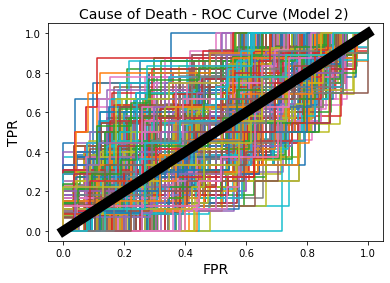

<Figure size 432x288 with 0 Axes>

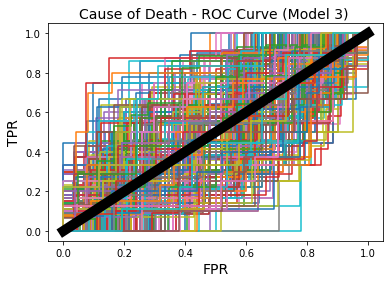

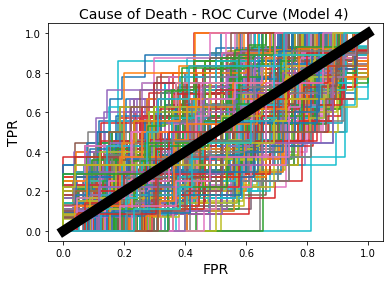

In [34]:

#Collecting stats on baseline 5 feature Log-regression prediction

baseone = []
basetwo = []
basethree = []
basefour = []


"""
fprone
fprtwo
fprthree
fprfour = np.empty
"""

fprone = []
tprone = []
fprtwo = []
tprtwo = []
fprthree = []
tprthree = []
fprfour = []
tprfour = []
threshstore = []

nsamp = 1000
for i in range(nsamp):
    
    np.random.shuffle(ind)
    X_train = X_trainvad[ind[:trainind],:]
    y_train = y_trainvad[ind[:trainind]]
    X_vad = X_trainvad[ind[trainind:],:]
    y_vad = y_trainvad[ind[trainind:]]
    
    #Model 1
    clf = LogisticRegression(random_state=0,p).fit(X_train[:,0:5], y_train)
    pred_prob = clf.predict_proba(X_vad[:,0:5]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    fprone.append(fpr)
    tprone.append(tpr)
    baseone.append(metrics.auc(fpr,tpr))
    #print("Model 1: AUC",metrics.auc(fpr,tpr))


    #Model 2
    clf = LogisticRegression(random_state=0,solver = 'saga',penalty='l1').fit(X_train[:,0:5], y_train)
    pred_prob = clf.predict_proba(X_vad[:,0:5]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    fprtwo.append(fpr)
    tprtwo.append(tpr)
    basetwo.append(metrics.auc(fpr,tpr))
    #print("Model 2: AUC",metrics.auc(fpr,tpr))


    #Model 3
    clf = LogisticRegression(random_state=0,solver = 'liblinear',penalty='l1').fit(X_train[:,0:5], y_train)
    pred_prob = clf.predict_proba(X_vad[:,0:5]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    fprthree.append(fpr)
    tprthree.append(tpr)
    basethree.append(metrics.auc(fpr,tpr))
    #print("Model 3: AUC",metrics.auc(fpr,tpr))


    #Model 4
    clf = LogisticRegression(random_state=0,penalty='l2').fit(X_train[:,0:5], y_train)
    pred_prob = clf.predict_proba(X_vad[:,0:5]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    fprfour.append(fpr)
    tprfour.append(tpr)
    threshstore.append(thresh)
    basefour.append(metrics.auc(fpr,tpr))
    #print("Model 4: AUC",metrics.auc(fpr,tpr))


#Storing data

nbaseone = [x for x in baseone if isnan(x) == False]
nbasetwo = [x for x in basetwo if isnan(x) == False]
nbasethree = [x for x in basethree if isnan(x) == False]
nbasefour = [x for x in basefour if isnan(x) == False]

baseone = np.array(nbaseone)
basetwo = np.array(nbasetwo)
basethree = np.array(nbasethree)
basefour = np.array(nbasefour)


upCIone = np.sort(baseone)[round(.975*nsamp)]
upCItwo =  np.sort(baseone)[round(.975*nsamp)]
upCIthree = np.sort(baseone)[round(.975*nsamp)]
upCIfour = np.sort(baseone)[round(.975*nsamp)]

lCIone =  np.sort(baseone)[round(.025*nsamp)]
lCItwo =  np.sort(basetwo)[round(.025*nsamp)]
lCIthree = np.sort(basethree)[round(.025*nsamp)]
lCIfour = np.sort(basefour)[round(.025*nsamp)]

#Get Confidence intervals 

print(".025%",lCIone,"Mean one:",np.mean(baseone),"97.5%",upCIone)
#print("Plus/minus one:",(np.std(baseone)/np.sqrt(nsamp)) * 1.984)

print(".025%",lCItwo,"Mean two:",np.mean(basetwo),"97.5%",upCItwo)
#print("Plus/minus two:",(np.std(basetwo)/np.sqrt(nsamp)) * 1.984)

print(".025%",lCIthree,"Mean three:",np.mean(basethree),"97.5%",upCIthree)
#print("Plus/minus three:",(np.std(basethree)/np.sqrt(nsamp)) * 1.984)

print(".025%",lCIfour,"Mean four:",np.mean(basefour),"97.5%",upCIfour)
#print("Plus/minus four:",(np.std(basefour)/np.sqrt(nsamp)) * 1.984)



poneind = np.argmin( np.abs(baseone - np.mean(baseone)) )
plt.figure()
plt.title("Cause of Death - ROC Curve (Model 1) ",fontsize=14)
plt.xlabel("FPR",fontsize=14)
plt.ylabel("TPR",fontsize=14)
for i in range(nsamp):
    plt.plot(fprone[i],tprone[i])
plt.plot(np.arange(11)/10,np.arange(11)/10,linewidth=10, color='black')
plt.show()



ptwoind = np.argmin( np.abs(basetwo - np.mean(basetwo)) )
plt.figure()
plt.figure()
plt.title("Cause of Death - ROC Curve (Model 2) ",fontsize=14)
plt.xlabel("FPR",fontsize=14)
plt.ylabel("TPR",fontsize=14)
for i in range(nsamp):
    plt.plot(fprtwo[i],tprtwo[i])
plt.plot(np.arange(11)/10,np.arange(11)/10,linewidth=10, color='black')
plt.show()



pthreeind = np.argmin( np.abs(basethree - np.mean(basethree)) )
plt.figure()
plt.figure()
plt.title("Cause of Death - ROC Curve (Model 3) ",fontsize=14)
plt.xlabel("FPR",fontsize=14)
plt.ylabel("TPR",fontsize=14)
for i in range(nsamp):
    plt.plot(fprthree[i],tprthree[i])
plt.plot(np.arange(11)/10,np.arange(11)/10,linewidth=10, color='black')
plt.show()



#pfourind = np.argmin( np.abs(basefour - np.mean(basefour)) )
plt.figure()
plt.title("Cause of Death - ROC Curve (Model 4) ",fontsize=14)
plt.xlabel("FPR",fontsize=14)
plt.ylabel("TPR",fontsize=14)
for i in range(nsamp):
    plt.plot(fprfour[i],tprfour[i])
plt.plot(np.arange(11)/10,np.arange(11)/10,linewidth=10, color='black')
plt.show()




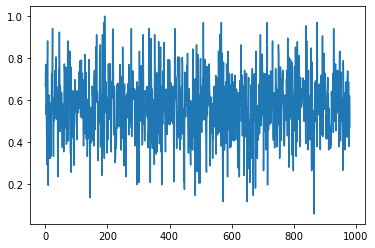

In [32]:
plt.plot(baseone)

In [10]:
print(ind[:trainind])
print(X_trainvad.shape)
print(X_trainvad[ind[:trainind],:])

[ 48  35  89  17  20   9  19  49  63  34  41  24  54  25  15  59  67  56
  70   5  13   0  38  29   2  30   8  47  99  94  27  60  22  16  92  26
  88  28  12  78  68  40  43  79   4  93  73 101   1  65 104  36  76  45
   7  32  23  98  61  91  31  87  96  95 105 102  97 100  44  53  58]
(159, 34)
[[ 5.  3.  0. ... 10.  6.  0.]
 [13.  6.  0. ...  9.  2.  0.]
 [13.  6.  0. ... 10.  3.  0.]
 ...
 [13.  6.  0. ... 10.  3.  0.]
 [13.  6.  0. ...  1.  2.  1.]
 [13.  6.  0. ...  9.  2.  2.]]


In [93]:
# For forwards/backwards selection, only grab first half of features to limit expense

nndfREC = ndfREC.iloc[:18,:]
nndfCOD = ndfCOD.iloc[:18,:]



In [94]:
#Raw forwards/backward selection
from scipy.stats import norm
#Load data
#X_train, y_train, X_vad, y_vad, X_test, y_test = process_train_data(nndfCOD.shape[0], CODtarg, nndfCOD, nfeatures)
#X_trainvad = np.concatenate((X_train,X_vad),axis=0)
#y_trainvad = np.concatenate((y_train,y_vad),axis=0)

#Define model
#clf = LogisticRegression(random_state=0,penalty = 'none').fit(X_train, y_train)
#pred_prob = clf.predict_proba(X_vad) # Getting probabilities


def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p


#Stepwise forwards selection
totalind = [] #Variable to store list of all indeces for cross validation

for a in range(100):
    #Reset for each validation
    np.random.shuffle(ind)
    X_train = X_trainvad[ind[:trainind],:]
    y_train = y_trainvad[ind[:trainind]]
    X_vad = X_trainvad[ind[trainind:],:]
    y_vad = y_trainvad[ind[trainind:]]



    #Initialize counter and add first feature to dataset
    k = 0
    minp = 1
    emptydata = X_train[:,0].reshape((X_train.shape[0],1)) 
    kindex = [0] #Used to tell model which features to test on
    indadd = [0] #Keeps track of all indeces added
    meanp = []
    lowp = []
    testvec = np.arange(X_train.shape[1])


    stop = X_train.shape[1] - 2
    while k < 6 or minp > .2: #only stops when avearge p-value is less than .2 and at least 5 features have been selected

        if k == stop:
            break

        attvar = [x for x in testvec if x not in np.array(indadd)]#Only test features that have not been added to model

        # For loop for adding variables
        for i in attvar:
            feat = X_train[:,i].reshape( (X_train[:,i].shape[0],1) ) # Gets features
            featest = np.hstack( (emptydata,feat) )
            indadd.append(i)
            
            clf =LogisticRegression(random_state=0,penalty='none').fit(featest, y_train)
            meanp.append(np.mean(logit_pvalue(clf, X_vad[:,indadd])[1:])) # (mean criteria for selecting pvalue)
            #print("Lowest p-value",logit_pvalue(clf, X_vad[:,indadd])[1:][-1])
            lowp.append(logit_pvalue(clf, X_vad[:,indadd])[1:][-1]) # Selecting last value of p-value (criteria for selecting feature)
            indadd = indadd[:-1]
        
   
        #indadd.append(attvar[np.argmin(meanp)]) #Getting feature that obtains lowest p-value
        #minp = np.min(meanp) #Get lowest average p value 
        
        indadd.append(attvar[np.argmin(lowp)]) #Getting feature that obtains lowest p-value
        minp = np.min(lowp) #Get lowest average p value        
        
        k = k + 1 #Counter

        #update emptydata
        emptydata = X_train[:,indadd]
        meanp = []
        lowp = []
        
    totalind.append(np.array(indadd))#Store features selected from cross-validation
ntotind = np.concatenate(totalind,axis=0)

#NOTE indadd gives you the most important features in order
    
    
def most_frequent(List):
    return max(set(List), key = List.count)

ntotind = ntotind.tolist()
topfeat = []
for i in range(5):
    mf = most_frequent(ntotind)
    ntotind = [x for x in ntotind if x!= mf ]
    topfeat.append(mf)
    
print("Top 5 features:",ndfREC.iloc[topfeat,0].values)



    

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: 

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

Top 5 features: ['CCRT Chemotherapy Regimen' 'N' 'Chemotherapy Regimen'
 'Pre-RT CT-derived lean body mass (kg)'
 'Pre-RT L3 Adipose Tissue Cross Sectional Area (cm2)']


/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/tmp/ipykernel_210475/1183784381.py:29: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

In [98]:
print(k)
print(stop)
print(minp)
print(a)
print("Model 1: Top 5 features:",ndfCOD.iloc[topfeat,0].values)

13
16
nan
99
Model 1: Top 5 features: ['Age' 'N' 'BMI start treat (kg/m2)' 'Oncologic Treatment Summary'
 'Pre-RT L3 Adipose Tissue Cross Sectional Area (cm2)']


In [96]:
print(topfeat)

[0, 12, 1, 15, 16]


/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

.025% 0.6839285714285714 Mean one: 0.7177035714285714 97.5% 0.7446428571428572


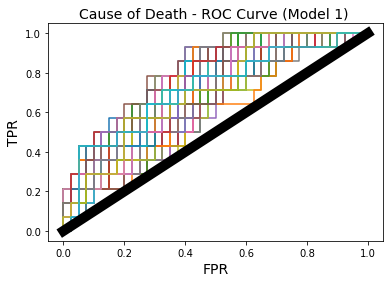

In [97]:
# GEtting AUCA RESULTS WITH feature selection

baseone = []
basetwo = []
basethree = []
basefour = []


"""
fprone
fprtwo
fprthree
fprfour = np.empty
"""

fprone = []
tprone = []
fprtwo = []
tprtwo = []
fprthree = []
tprthree = []
fprfour = []
tprfour = []


nsamp = 1000
for i in range(nsamp):
    
    np.random.shuffle(ind)
    X_train = X_trainvad[ind[:trainind],:]
    y_train = y_trainvad[ind[:trainind]]
    X_vad = X_trainvad[ind[trainind:],:]
    y_vad = y_trainvad[ind[trainind:]]
    

    #Model 1
    clf = LogisticRegression(random_state=0,penalty = 'none').fit(X_train[:,topfeat], y_train)
    pred_prob = clf.predict_proba(X_test[:,topfeat]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_test,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    fprone.append(fpr)
    tprone.append(tpr)
    baseone.append(metrics.auc(fpr,tpr))
    #print("Model 1: AUC",metrics.auc(fpr,tpr))



#Storing data

nbaseone = [x for x in baseone if isnan(x) == False]
baseone = np.array(nbaseone)
upCIone = np.sort(baseone)[round(.975*nsamp)]
lCIone =  np.sort(baseone)[round(.025*nsamp)]


#Get Confidence intervals 

print(".025%",lCIone,"Mean one:",np.mean(baseone),"97.5%",upCIone)
#print("Plus/minus one:",(np.std(baseone)/np.sqrt(nsamp)) * 1.984)
poneind = np.argmin( np.abs(baseone - np.mean(baseone)) )
plt.figure()
plt.title("Cause of Death - ROC Curve (Model 1) ",fontsize=14)
plt.xlabel("FPR",fontsize=14)
plt.ylabel("TPR",fontsize=14)
for i in range(nsamp):
    plt.plot(fprone[i],tprone[i])
plt.plot(np.arange(11)/10,np.arange(11)/10,linewidth=10, color='black')
plt.show()





In [35]:
print(topfeat)

[0, 12, 16, 2, 15]


In [10]:
#Forwards/Backwards Selection


#auc list
fwdmone = []
bwdmone = []
fwdmtwo = []
bwdmtwo = []
fwdmthree = []
bwdmthree = []
fwdmfour = []
bwdmfour = []

#index list
fwdmoneind = []
bwdmoneind = []
fwdmtwoind = []
bwdmtwoind = []
fwdmthreeind = []
bwdmthreeind = []
fwdmfourind = []
bwdmfourind = []

#Redefine data fram 

nsamp = 1000
for i in range(nsamp):
    
    print("Iteration: ",i)
    
    #Need to perform stratified K-fold between training/validation data for feature selection/hyperparameter tuning
    X_train, y_train, X_vad, y_vad, X_test, y_test = process_train_data(nndfCOD.shape[0], CODtarg, nndfCOD, nfeatures)


    #Merge training and validation data such that cross-validation can be performed

    X_trainvad = np.concatenate((X_train,X_vad),axis=0)
    y_trainvad = np.concatenate((y_train,y_vad),axis=0)
    print(np.shape(X_trainvad))

    # Performing forward/backward selection with no feature importance
    from sklearn.feature_selection import SequentialFeatureSelector

    #Model 1
    clf = LogisticRegression(random_state=0,penalty = 'none')
    sfsd = SequentialFeatureSelector(clf,n_features_to_select="auto",tol=0.00001 ,scoring='r2')
    sfsd.fit(X_trainvad,y_trainvad)
    findex = np.argwhere(sfsd.get_support() == True).squeeze()
    sfs = SequentialFeatureSelector(clf,n_features_to_select="auto",tol=0.00001, scoring='r2',direction='backward')
    sfs.fit(X_trainvad,y_trainvad)
    bindex = np.argwhere(sfs.get_support() == True).squeeze()
    
    
    
    if np.size(findex) == 1:
        fwdmoneind.append(findex)
    else:
        fwdmoneind.append(list(findex))
        
    if np.size(bindex) == 1:
        bwdmoneind.append(bindex)
    else:
        bwdmoneind.append(list(bindex))

    
    #Model evaluation(forward)
    clf = LogisticRegression(random_state=0,penalty= 'none').fit(X_train[:,findex], y_train)
    pred_prob = clf.predict_proba(X_vad[:,findex]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    fwdmone.append(metrics.auc(fpr,tpr))
    #print("Model 1:Forwards AUC",metrics.auc(fpr,tpr))
    #print("Forward",dfCOD.iloc[findexmone,0].values)

    #Model evaluation(backward)
    clf = LogisticRegression(random_state=0,penalty = 'none').fit(X_train[:,bindex], y_train)
    pred_prob = clf.predict_proba(X_vad[:,bindex]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    bwdmone.append(metrics.auc(fpr,tpr))
    #print("Model 1:Backwards AUC",metrics.auc(fpr,tpr))
    #print("Backwards",dfCOD.iloc[bindexmone,0].values)


    #Model 2
    clf = LogisticRegression(random_state=0,solver = 'saga',penalty='l1')
    sfs = SequentialFeatureSelector(clf,n_features_to_select="auto",tol=0.01,scoring='r2')
    sfs.fit(X_trainvad,y_trainvad)
    findex = np.argwhere(sfs.get_support() == True).squeeze()
    sfs = SequentialFeatureSelector(clf,n_features_to_select="auto",tol=0.01,scoring='r2',direction='backward')
    sfs.fit(X_trainvad,y_trainvad)
    bindex = np.argwhere(sfs.get_support() == True).squeeze()
        
    
    if np.size(findex) == 1:
        fwdmtwoind.append(findex)
    else:
        fwdmtwoind.append(list(findex))
        
    if np.size(bindex) == 1:
        bwdmtwoind.append(bindex)
    else:
        bwdmtwoind.append(list(bindex))

    
    #Model evaluation(forward)
    clf = LogisticRegression(random_state=0,solver = 'saga',penalty='l1').fit(X_train[:,findex], y_train)
    pred_prob = clf.predict_proba(X_vad[:,findex]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    fwdmtwo.append(metrics.auc(fpr,tpr))
    #print("Model 1:Forwards AUC",metrics.auc(fpr,tpr))
    #print("Forward",dfCOD.iloc[findexmone,0].values)

    #Model evaluation(backward)
    clf = LogisticRegression(random_state=0,solver = 'saga',penalty='l1').fit(X_train[:,bindex], y_train)
    pred_prob = clf.predict_proba(X_vad[:,bindex]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    bwdmtwo.append(metrics.auc(fpr,tpr))
    #print("Model 1:Backwards AUC",metrics.auc(fpr,tpr))
    #print("Backwards",dfCOD.iloc[bindexmone,0].values)


    #Model 3
    clf = LogisticRegression(random_state=0,solver = 'liblinear',penalty='l1')
    sfs = SequentialFeatureSelector(clf,n_features_to_select="auto",tol=0.0001,scoring='r2')
    sfs.fit(X_trainvad,y_trainvad)
    findex = np.argwhere(sfs.get_support() == True).squeeze()
    sfs = SequentialFeatureSelector(clf,n_features_to_select="auto",tol=0.0001,scoring='r2',direction='backward')
    sfs.fit(X_trainvad,y_trainvad)
    bindex = np.argwhere(sfs.get_support() == True).squeeze()
    
    
    if np.size(findex) == 1:
        fwdmthreeind.append(findex)
    else:
        fwdmthreeind.append(list(findex))
        
    if np.size(bindex) == 1:
        bwdmthreeind.append(bindex)
    else:
        bwdmthreeind.append(list(bindex))

    
    #Model evaluation(forward)
    clf = LogisticRegression(random_state=0,solver = 'liblinear',penalty='l1').fit(X_train[:,findex], y_train)
    pred_prob = clf.predict_proba(X_vad[:,findex]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    fwdmthree.append(metrics.auc(fpr,tpr))
    #print("Model 1:Forwards AUC",metrics.auc(fpr,tpr))
    #print("Forward",dfCOD.iloc[findexmone,0].values)

    #Model evaluation(backward)
    clf = LogisticRegression(random_state=0,solver = 'liblinear',penalty='l1').fit(X_train[:,bindex], y_train)
    pred_prob = clf.predict_proba(X_vad[:,bindex]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    bwdmthree.append(metrics.auc(fpr,tpr))
    #print("Model 1:Backwards AUC",metrics.auc(fpr,tpr))
    #print("Backwards",dfCOD.iloc[bindexmone,0].values)

    #Model 4
    clf = LogisticRegression(random_state=0,penalty='l2')
    sfs = SequentialFeatureSelector(clf,n_features_to_select="auto",tol=0.01,scoring='r2')
    sfs.fit(X_trainvad,y_trainvad)
    findex = np.argwhere(sfs.get_support() == True).squeeze()
    sfs = SequentialFeatureSelector(clf,n_features_to_select="auto",tol=0.01,scoring='r2',direction='backward')
    sfs.fit(X_trainvad,y_trainvad)
    bindex = np.argwhere(sfs.get_support() == True).squeeze()
    
    
    if np.size(findex) == 1:
        fwdmfourind.append(findex)
    else:
        fwdmfourind.append(list(findex))
        
    if np.size(bindex) == 1:
        bwdmfourind.append(bindex)
    else:
        bwdmfourind.append(list(bindex))


    #Model evaluation(forward)
    clf = LogisticRegression(random_state=0,penalty='l2').fit(X_train[:,findex], y_train)
    pred_prob = clf.predict_proba(X_vad[:,findex]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    fwdmfour.append(metrics.auc(fpr,tpr))
    #print("Model 1:Forwards AUC",metrics.auc(fpr,tpr))
    #print("Forward",dfCOD.iloc[findexmone,0].values)

    #Model evaluation(backward)
    clf = LogisticRegression(random_state=0,penalty='l2').fit(X_train[:,bindex], y_train)
    pred_prob = clf.predict_proba(X_vad[:,bindex]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    bwdmfour.append(metrics.auc(fpr,tpr))
    #print("Model 1:Backwards AUC",metrics.auc(fpr,tpr))
    #print("Backwards",dfCOD.iloc[bindexmone,0].values)

Iteration:  0
(159, 18)


/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

ValueError: Expected 2D array, got 1D array instead:
array=[29. 44. 52. 53. 47. 57. 91. 57. 51. 45. 48. 62. 53. 58. 50. 58. 66. 63.
 63. 48. 53. 73. 64. 50. 77. 46. 56. 61. 43. 41. 47. 57. 34. 48. 51. 59.
 66. 51. 54. 54. 62. 44. 67. 57. 73. 61. 57. 54. 63. 47. 53. 56. 53. 68.
 58. 50. 61. 66. 68. 51. 52. 55. 72. 59. 66. 50. 65. 45. 54. 72. 76. 57.
 60. 45. 77. 58. 75. 66. 54. 44. 50. 65. 53. 54. 54. 51. 54. 54. 50. 69.
 66. 48. 56. 35. 45. 67. 70. 51. 50. 46. 59. 55. 50. 50. 71. 50.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
print(sfsd.get_params())
from sklearn.metrics import r2_score
sfsd = SequentialFeatureSelector(clf,n_features_to_select="auto",tol=-.001 ,scoring='max_error')
print(sfsd.fit(X_trainvad,y_trainvad))
sfsd.get_support()

In [ ]:
    

print("Forwards")
    
print("mone AUC",np.mean(fwdmone))
print("mone +/- : ",np.std(fwdmone)/np.sqrt(nsamp) * 1.984)
print("mtwo AUC",np.mean(fwdmtwo))
print("mtwo +/- : ",np.std(fwdmtwo)/np.sqrt(nsamp) * 1.984)
print("mthree AUC",np.mean(fwdmthree))
print("mthree +/- : ",np.std(fwdmthree)/np.sqrt(nsamp) * 1.984)
print("mfour AUC",np.mean(fwdmfour))
print("mfour +/- :",np.std(fwdmfour)/np.sqrt(nsamp) * 1.984)

print("Backwards")

print("mone AUC",np.mean(bwdmone))
print("mone +/- : ",np.std(bwdmone)/np.sqrt(nsamp) * 1.984)
print("mtwo AUC",np.mean(bwdmtwo))
print("mtwo +/- : ",np.std(bwdmtwo)/np.sqrt(nsamp) * 1.984)
print("mthree AUC",np.mean(bwdmthree))
print("mthree +/- : ",np.std(bwdmthree)/np.sqrt(nsamp) * 1.984)
print("mfour AUC",np.mean(bwdmfour))
print("mfour +/- : ",np.std(bwdmfour)/np.sqrt(nsamp) * 1.984)

print("Most important features:")


bwdmoneind = [x for xs in bwdmoneind for x in xs]
bwdmtwoind = [x for xs in bwdmtwoind for x in xs]
bwdmthreeind = [x for xs in bwdmthreeind for x in xs]
bwdmfourind = [x for xs in bwdmfourind for x in xs]
fwdmoneind = [x for xs in fwdmoneind for x in xs]
fwdmtwoind = [x for xs in fwdmtwoind for x in xs]
fwdmthreeind = [x for xs in fwdmthreeind for x in xs]
fwdmfourind = [x for xs in fwdmfourind for x in xs]


from statistics import mode
def grabind(indlist):
    
    tpind = []
    for i in range(3):
        tpind.append(mode(indlist))
        tester = [item for item in indlist if item != mode(indlist)]
        
    return tpind

print(dfREC.iloc[grabind(bwdmoneind),0].values)
print(dfREC.iloc[grabind(bwdmtwoind),0].values)
print(dfREC.iloc[grabind(bwdmthreeind),0].values)
print(dfREC.iloc[grabind(bwdmfourind),0].values)
print(dfREC.iloc[grabind(fwdmoneind),0].values)
print(dfREC.iloc[grabind(fwdmtwoind),0].values)
print(dfREC.iloc[grabind(fwdmthreeind),0].values)
print(dfREC.iloc[grabind(fwdmfourind),0].values)

In [ ]:
print(i)

In [ ]:
from statistics import mode
tester = [1,1,1,1,4,5,6,6,3,3,3,3,3,3]

def grabind(indlist):
    
    tpind = []
    for i in range(3):
        tpind.append(mode(indlist))
        tester = [item for item in indlist if item != mode(indlist)]
        
    return tpind
    
print(type(bwdmtwoind))
print(type(tester))

print(tester)
print(bwdmoneind[0])



print(dfREC.iloc[grabind(bwdmoneind[0]),0].values)


In [ ]:
print("One",dfREC.iloc[fwdmoneind[0],0].values)
print("")
print("Two",dfREC.iloc[fwdmtwoind[0],0].values)
print("")
print("Three",dfREC.iloc[fwdmthreeind[0],0].values)
print("")
print("Four",dfREC.iloc[fwdmfourind[0],0].values)

In [ ]:
#Recording data from Forward/Backwards selection results

print(np.mean(fwdmone))
print(np.mean(fwdmtwo))
print(np.mean(fwdmthree))
print(np.mean(fwdmfour))

print(np.mean(bwdmone))
print(np.mean(bwdmtwo))
print(np.mean(bwdmthree))
print(np.mean(bwdmfour))


In [ ]:


print(np.std(fwdmone)/np.sqrt(2))
print(np.std(fwdmtwo)/np.sqrt(2))
print(np.std(fwdmthree)/np.sqrt(2))
print(np.std(fwdmfour)/np.sqrt(2))

print(np.std(bwdmone)/np.sqrt(2))
print(np.std(bwdmtwo)/np.sqrt(2))
print(np.std(bwdmthree)/np.sqrt(2))
print(np.std(bwdmfour)/np.sqrt(2))




In [11]:
print(topfeat)

[0, 13, 16, 1, 15]


In [51]:
#Hyperparameter Tuning


#Define parameter grid dictionary
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(1e-5, 100, ),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500, 5000]
    }
]



#Perform random search

#Specify model

logistic = LogisticRegression(random_state=0,penalty = 'None') # Model 1
#logistic = LogisticRegression(random_state=0,solver = 'saga',penalty='l1') #Model 2
#logistic = LogisticRegression(random_state=0,solver = 'liblinear',penalty='l1') #Model 3
#logistic = LogisticRegression(random_state=0,penalty='l2') #Model 4


clf = RandomizedSearchCV(logistic,param_grid,random_state=0,n_iter=60) # Prior from probablity theory tells us 60 iterations is optimal


nsamp = 10
hypersearch = []
fprhyper = []
tprhyper = []
hypertunedauc = []
for i in range(nsamp):
    
    np.random.shuffle(ind)
    X_train = X_trainvad[ind[:trainind],:]
    y_train = y_trainvad[ind[:trainind]]
    X_vad = X_trainvad[ind[trainind:],:]
    y_vad = y_trainvad[ind[trainind:]]

    search = clf.fit(X_trainvad[:,topfeat],y_trainvad)
    hypersearch.append(list(search.best_params_.values()))
    
    #Test optimized model with optimal hyperparameters/optimal number of predictor variables

    #Model test
    clf = LogisticRegression(random_state=0,solver = search.best_params_["solver"],C = search.best_params_["C"],max_iter = search.best_params_["max_iter"],penalty = search.best_params_["penalty"]).fit(X_train[:,topfeat], y_train)
    pred_prob = clf.predict_proba(X_vad[:,topfeat]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    fprhyper.append(fpr)
    tprhyper.append(tpr)
    hypertunedauc.append(metrics.auc(fpr,tpr))


#Storing data

nbaseone = [x for x in hypertunedauc if isnan(x) == False]
baseone = np.array(nbaseone)
upCIone = np.sort(baseone)[round(.975*nsamp)]
lCIone =  np.sort(baseone)[round(.025*nsamp)]


#Get Confidence intervals 
print(".025%",lCIone,"Mean one:",np.mean(baseone),"97.5%",upCIone)
#print("Plus/minus one:",(np.std(baseone)/np.sqrt(nsamp)) * 1.984)
poneind = np.argmin( np.abs(baseone - np.mean(baseone)) )
plt.figure()
plt.title("Cause of Death - ROC Curve (Model 1) ",fontsize=14)
plt.xlabel("FPR",fontsize=14)
plt.ylabel("TPR",fontsize=14)
for i in range(nsamp):
    plt.plot(fprhyper[i],tprhyper[i])
plt.plot(np.arange(11)/10,np.arange(11)/10,linewidth=10, color='black')
plt.show()
 
    
    
    

#bestAUC = np.max([baseone,basetwo,basethree,basefour,optbackauc,optfwdauc,hypertunedauc])
#print(bestAUC)

#sys.exit()

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


AttributeError: 'LogisticRegression' object has no attribute 'best_params_'

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/li

.025% 0.6803571428571429 Mean one: 0.7182642857142857 97.5% 0.7446428571428572


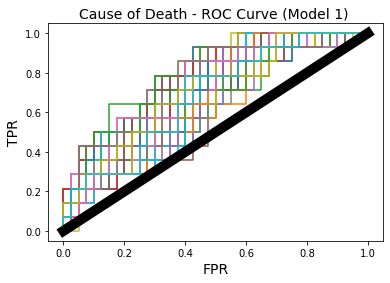

In [100]:
#Hyperparamter tuning

#Define parameter grid dictionary
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(1e-5, 100, ),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500, 5000]
    }
]



#Perform random search

#Specify model

logistic = LogisticRegression(random_state=0,penalty = 'None') # Model 1
#logistic = LogisticRegression(random_state=0,solver = 'saga',penalty='l1') #Model 2
#logistic = LogisticRegression(random_state=0,solver = 'liblinear',penalty='l1') #Model 3
#logistic = LogisticRegression(random_state=0,penalty='l2') #Model 4


clf = RandomizedSearchCV(logistic,param_grid,random_state=0,n_iter=60) # Prior from probablity theory tells us 60 iterations is optimal
search = clf.fit(X_trainvad[:,topfeat],y_trainvad)

nsamp = 1000
hypersearch = []
fprhyper = []
tprhyper = []
hypertunedauc = []
for i in range(nsamp):
    
    
    np.random.shuffle(ind)
    X_train = X_trainvad[ind[:trainind],:]
    y_train = y_trainvad[ind[:trainind]]
    X_vad = X_trainvad[ind[trainind:],:]
    y_vad = y_trainvad[ind[trainind:]]
    
    #Test optimized model with optimal hyperparameters/optimal number of predictor variables

    #Model test
    clf = LogisticRegression(random_state=0,solver = search.best_params_["solver"],C = search.best_params_["C"],max_iter = search.best_params_["max_iter"],penalty = search.best_params_["penalty"]).fit(X_train[:,topfeat], y_train)
    pred_prob = clf.predict_proba(X_test[:,topfeat]) # Getting probabilities
    #Get roc curve 
    fpr,tpr,thresh = roc_curve(y_test,pred_prob[:,1]) #NOTE need to feed probabilities of positive class
    fprhyper.append(fpr)
    tprhyper.append(tpr)
    hypertunedauc.append(metrics.auc(fpr,tpr))


#Storing data

nbaseone = [x for x in hypertunedauc if isnan(x) == False]
baseone = np.array(nbaseone)
upCIone = np.sort(baseone)[round(.975*nsamp)]
lCIone =  np.sort(baseone)[round(.025*nsamp)]


#Get Confidence intervals 
print(".025%",lCIone,"Mean one:",np.mean(baseone),"97.5%",upCIone)
#print("Plus/minus one:",(np.std(baseone)/np.sqrt(nsamp)) * 1.984)
poneind = np.argmin( np.abs(baseone - np.mean(baseone)) )
plt.figure()
plt.title("Cause of Death - ROC Curve (Model 1) ",fontsize=14)
plt.xlabel("FPR",fontsize=14)
plt.ylabel("TPR",fontsize=14)
for i in range(nsamp):
    plt.plot(fprhyper[i],tprhyper[i])
plt.plot(np.arange(11)/10,np.arange(11)/10,linewidth=10, color='black')
plt.show()
 
    
    
    

#bestAUC = np.max([baseone,basetwo,basethree,basefour,optbackauc,optfwdauc,hypertunedauc])
#print(bestAUC)

#sys.exit()

In [79]:
print(clf)
print("Best parameters",search.best_params_)
liset = search.best_params_.values()
print(list(liset))

LogisticRegression(C=2.120991751674197e+16, max_iter=1000, random_state=0,
                   solver='sag')
Best parameters {'solver': 'sag', 'penalty': 'l2', 'max_iter': 1000, 'C': 2.120991751674197e+16}
['sag', 'l2', 1000, 2.120991751674197e+16]


In [ ]:
"""
#Splitting based on percentages

#Model forward selection
maxAUCindfwd = []
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_index, vad_index, in skf.split(X_trainvad,y_trainvad):
    
    AUCforward = []
    for i in range(5,dfREC.shape[0]): 
        
        X_train, X_vad = X_trainvad[train_index,0:i], X_trainvad[vad_index,0:i]
        y_train, y_vad = y_trainvad[train_index], y_trainvad[vad_index]
        #!!!!!!!!!!!!!!!!!
        #NOTE 
        #Change model here
        #clf = LogisticRegression(random_state=0,class_weight='balanced').fit(X_train, y_train) # Model 1
        #clf = LogisticRegression(random_state=0,class_weight='balanced',solver = 'saga',penalty='l1').fit(X_train, y_train) # Model 2
        clf = LogisticRegression(random_state=0,class_weight='balanced',solver = 'liblinear',penalty='l1').fit(X_train, y_train) #Model 3
        #clf = LogisticRegression(random_state=0,class_weight='balanced',penalty='l2').fit(X_train, y_train) #Model 4
        #!!!!!!!!!!!!!!!

        pred_prob = clf.predict_proba(X_vad)# Getting probabilities
        fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1])
        AUCforward.append(metrics.auc(fpr,tpr)) # Storing AUC values as a function of number of predictor variables
        
        
    maxAUCindfwd.append(np.argmax(AUCforward)+5)
    
round(np.mean(maxAUCindfwd))
optnumbfeatfwd = round(np.mean(maxAUCindfwd))
print("Average index of max AUC:",optnumbfeatfwd)


#Testing out forward selection with optimal number of features
#clf = LogisticRegression(random_state=0,class_weight='balanced').fit(X_train[:,0:optnumbfeatfwd], y_train) #Model 1
#clf = LogisticRegression(random_state=0,class_weight='balanced',solver = 'saga',penalty='l1').fit(X_train[:,0:optnumbfeatfwd], y_train) # Model 2
clf = LogisticRegression(random_state=0,class_weight='balanced',solver = 'liblinear',penalty='l1').fit(X_train[:,0:optnumbfeatfwd], y_train) # Model 3
#clf = LogisticRegression(random_state=0,class_weight='balanced',penalty='l2').fit(X_train[:,0:optnumbfeatfwd], y_train) #Model 4
pred_prob = clf.predict_proba(X_vad[:,0:optnumbfeatfwd])# Getting probabilitiese 
fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1])

optfwdauc = metrics.auc(fpr,tpr)
print("Optimal AUC using forward selection",optfwdauc) # Storing AUC values as a function of number of predictor variables

        
plt.figure()
plt.title("ROC Curve-Optimized forwards selection")
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(["Logistic","No Skill"])



# Backwards selection to determine optimal number of features
#Model backwards selection
maxAUCindback = []
for train_index, vad_index, in skf.split(X_trainvad,y_trainvad):
    
    
    AUCback = []
    for i in range(dfREC.shape[0],5,-1): 
                
        X_train, X_vad = X_trainvad[train_index,0:i], X_trainvad[vad_index,0:i]
        y_train, y_vad = y_trainvad[train_index], y_trainvad[vad_index]
        
        #!!!!!!!!!!!!!!!!!
        #NOTE 
        #Change model here
        #clf = LogisticRegression(random_state=0,class_weight='balanced').fit(X_train, y_train) #Model 1
        #clf = LogisticRegression(random_state=0,class_weight='balanced',solver = 'saga',penalty='l1').fit(X_train, y_train) #Model 2
        clf = LogisticRegression(random_state=0,class_weight='balanced',solver = 'liblinear',penalty='l1').fit(X_train, y_train) #Model 3
        #clf = LogisticRegression(random_state=0,class_weight='balanced',penalty='l2').fit(X_train, y_train) # Model 4
        #!!!!!!!!!!!!!!!


        pred_prob = clf.predict_proba(X_vad)# Getting probabilities
        fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1])
        AUCback.append(metrics.auc(fpr,tpr)) # Storing AUC values as a function of number of predictor variables
        
    maxAUCindback.append(np.argmax(AUCback))
    
round(np.mean(maxAUCindback))
optnumbfeatback = round(np.mean(maxAUCindback))
print("Average index of max AUC:",optnumbfeatback)

#Testing out forward selection with optimal number of features
#clf = LogisticRegression(random_state=0,class_weight='balanced').fit(X_train[:,0:optnumbfeatback], y_train) # Model 1
#clf = LogisticRegression(random_state=0,class_weight='balanced',solver = 'saga',penalty='l1').fit(X_train[:,0:optnumbfeatback], y_train) #Model 2
clf = LogisticRegression(random_state=0,class_weight='balanced',solver = 'liblinear',penalty='l1').fit(X_train[:,0:optnumbfeatback], y_train) #Model 3
#clf = LogisticRegression(random_state=0,class_weight='balanced',penalty='l2').fit(X_train[:,0:optnumbfeatback], y_train) # Model 4
pred_prob = clf.predict_proba(X_vad[:,0:optnumbfeatback])# Getting probabilities
fpr,tpr,thresh = roc_curve(y_vad,pred_prob[:,1])

optbackauc = metrics.auc(fpr,tpr)
print("Optimal AUC using Backwards selection selection",optbackauc) # Storing AUC values as a function of number of predictor variables
        
plt.figure()
plt.title("ROC Curve-Optimized backwards selection")
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(["Logistic","No Skill"])


#Getting optimal number of indeces from forward/backwards selection based on AUC
maxauc = np.argmax([optbackauc,optfwdauc])

if maxauc == 0:
    numbfeat = optnumbfeatback 
if maxauc == 1:
    numbfeat = optnumbfeatfwd

"""